#**EEG analysis**

## **Import and Definitions**

In [1]:
! pip install mne
! pip install fooof

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 KB 1.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import mne
import pickle
import os
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib

from pathlib import Path
from IPython.display import clear_output
from mne.datasets import fetch_fsaverage
# from mne.time_frequency import psd_multitaper
from mne.minimum_norm import make_inverse_operator, apply_inverse_raw, compute_source_psd
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model
from fooof.sim.gen import gen_aperiodic

Mounted at /content/drive


In [6]:
prepro_data_folder_dir = '/content/drive/MyDrive/Research/Sage/data'
folder_list = os.listdir(prepro_data_folder_dir)
folder_list = [folder for folder in folder_list if folder.startswith('sub')]

subject_analysis_dict = {}

analysis_list = ['all_ch_relative_power','sig_ch_relative_power','reg_relative_power','all_lab_relative_power','sig_lab_relative_power']
#Example call: subject_analysis_dict[file_name][analysis_list[i]][band]

bands = [
    ("theta", 4, 8),
    ("alpha", 8, 12),
    ("beta", 12, 30),
    ("low gamma", 30, 45),
    ("broad", 4, 45)
]

##***Channel-Wise & Region-Wise Relative Power Analysis***

### Pre-defined variables and functions

In [ ]:
# Channel analysis variables
ch_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 
 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 
 'P1', 'P2', 'C1', 'C2', 'FT9', 'FT10', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 
 'C5', 'C6', 'P5', 'P6', 'PO9', 'Iz', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'PO10', 'CPz', 'POz']

num_ch = len(ch_names)

def integrate(evo_psds, freqs, low, upper):
    inds = [i for i in range(len(freqs)) if low < freqs[i] <= upper]
    if len(inds) == 0: return np.zeros((evo_psds.shape[0]))
    evo_psds = evo_psds[:, inds[0]:inds[-1]+1].sum(axis=1)
    return evo_psds, len(inds)

In [ ]:
# Region analysis variables
ch_dict = {}
for name in ch_names:
    if name.startswith('F') or name.startswith('A'): ch_dict[name] = "frontal"
    elif name.startswith('C'): ch_dict[name] = "central"
    elif name.startswith('T'): ch_dict[name] = "temporal"    
    elif name.startswith('P'): ch_dict[name] = "parietal"
    elif name.startswith('O') or name.startswith('I'): ch_dict[name] = "occipital"

region_list = ["frontal","central","temporal","parietal","occipital"]

region_dict = {
    "frontal": [name for name in ch_names if name.startswith('F') or name.startswith('A')],
    "central": [name for name in ch_names if name.startswith('C')],
    "temporal": [name for name in ch_names if name.startswith('T')],
    "parietal": [name for name in ch_names if name.startswith('P')],
    "occipital": [name for name in ch_names if name.startswith('O') or name.startswith('I')],
}

def regional_integration(evo_psds, freqs):
    regional_evo_psds = np.zeros((len(region_dict),evo_psds.shape[1]))
    for i in range(len(region_list)):
        region = region_list[i]
        evo_psds_by_region = np.array([evo_psds[i] for i in range(len(ch_dict)) if ch_dict[ch_names[i]] == region])
        evo_psds_by_region = evo_psds_by_region.sum(axis=0)/np.shape(evo_psds_by_region)[0]
        regional_evo_psds[i] = evo_psds_by_region
    return regional_evo_psds

### Relative Power Ratio per subject for all channels and all regions

In [ ]:
num_p, num_h = 0, 0
max_read_num = 120
for folder_name in folder_list:
    print(num_p,num_h)

    # generate one slot of analysis for the file
    file_name = folder_name[4:]
    subject_analysis_dict[file_name] = {}
    subject_analysis_dict[file_name][analysis_list[0]] = {}
    subject_analysis_dict[file_name][analysis_list[2]] = {}

    Is_patient = 0 if file_name[-4:-2]=='hc' else 1 

    if(num_p > max_read_num and num_h > max_read_num): break
    elif(num_h > max_read_num and not Is_patient): print("controls are full")
    elif(num_p > max_read_num and Is_patient): print("patients are full")
    else:
      if(Is_patient): num_p += 1
      else: num_h += 1    
      # read raw file
      folder_path = os.path.join(prepro_data_folder_dir,folder_name,'eeg')
      file_path = os.path.join(folder_path, folder_name+'_task-closed_eeg_preprocessed.fif')
      raw = mne.io.read_raw_fif(file_path,preload=True)
      
      # compute psd by multitaper
      evo_psds, freqs = (raw.compute_psd(method='multitaper', fmin=4, fmax=45)).get_data(return_freqs=True)
      # aperiodic feature removal
      #   Average
      average_spec = evo_psds.mean(0)
      #   Average fit
      fm = FOOOF()
      fm.fit(freqs=freqs, power_spectrum=average_spec, freq_range=[4,45])
      average_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))# Example
      for i in range(len(evo_psds)):
        ex_fm = FOOOF()
        ex_fm.add_data(freqs=freqs, power_spectrum=evo_psds[i], freq_range=[4,45])
        # Noise reduction
        flat_spec = ex_fm.power_spectrum - average_ap_fit
        # plot_spectrum(freqs, flat_spec, log_powers=False, color='black', label='1/f reduction Spectrum')
        evo_psds[i] = flat_spec
      reg_evo_psds = regional_integration(evo_psds, freqs)
      
      # compute power ratio between each band and broadband signal for the file
      broad_band_power_sum, broad_band_len = integrate(evo_psds, freqs, bands[-1][1], bands[-1][2])
      reg_broad_band_power_sum, reg_broad_band_len = integrate(reg_evo_psds, freqs, bands[-1][1], bands[-1][2])
      for band, low, upper in bands[:-1]:
          power_sum, band_len = integrate(evo_psds, freqs, low, upper)
          reg_power_sum, band_len = integrate(reg_evo_psds, freqs, low, upper)
          subject_analysis_dict[file_name][analysis_list[0]][band] = power_sum/broad_band_power_sum
          subject_analysis_dict[file_name][analysis_list[2]][band] = reg_power_sum/reg_broad_band_power_sum
    clear_output(wait=True)
    print(f"calculating relative power ratios from {num_p} patients and {num_h} healthy controls")

calculating relative power ratios from 101 patients and 88 healthy controls


### Relative Power Ratio per subject for significant channels

In [ ]:
# Classify subject data by patients and controls
p_power_dict = {'theta':np.zeros((0,num_ch)),'alpha':np.zeros((0,num_ch)),'beta':np.zeros((0,num_ch)),'low gamma':np.zeros((0,num_ch))}
h_power_dict = p_power_dict.copy()

num_p, num_h = 0, 0
for folder_name in folder_list:
    print(num_p,num_h)
    file_name = folder_name[4:]
    Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
    if(num_p > max_read_num and num_h > max_read_num): break
    elif(num_h > max_read_num and not Is_patient): print("controls are full")
    elif(num_p > max_read_num and Is_patient): print("patients are full")
    else:
      if(Is_patient): num_p += 1
      else: num_h += 1 
      for band, low, upper in bands[:-1]:
          temp = subject_analysis_dict[file_name][analysis_list[0]][band]
          if(Is_patient): p_power_dict[band] = np.vstack((p_power_dict[band],temp))
          else: h_power_dict[band] = np.vstack((h_power_dict[band],temp))
      clear_output(wait=True)

100 88


theta
5 ['TP10', 'CP3', 'CP4', 'PO3', 'FT8']
alpha
4 ['FC2', 'C2', 'CP4', 'FT8']
beta
6 ['FC1', 'FC2', 'FT9', 'PO3', 'FT7', 'FT8']
low gamma
5 ['FC1', 'FC2', 'C2', 'FT7', 'FT8']


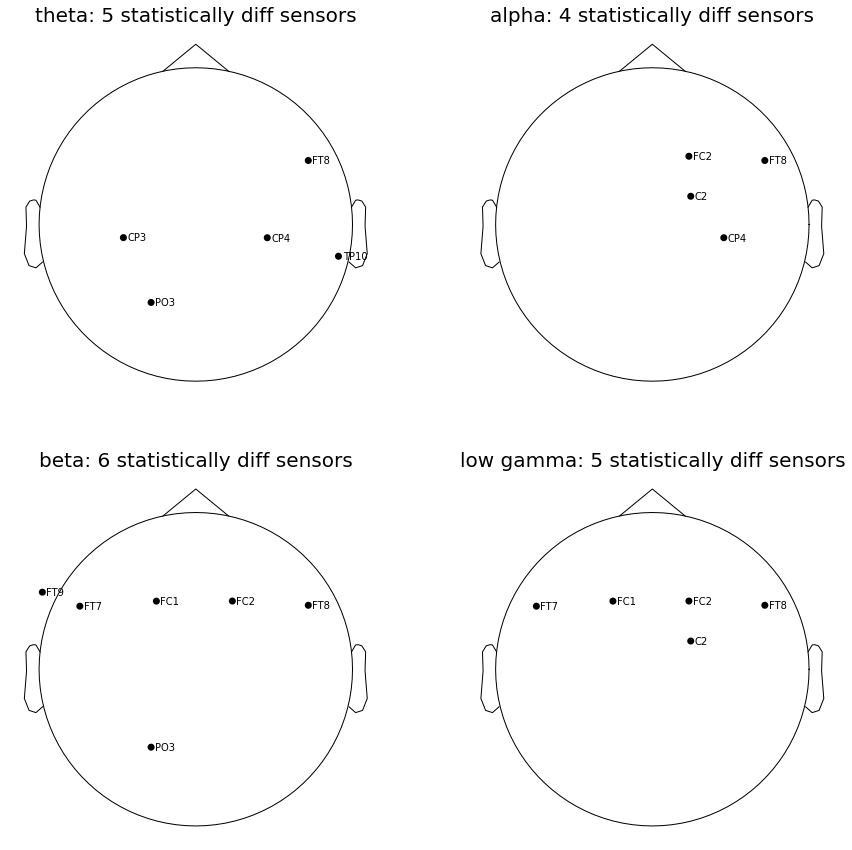

In [ ]:
# Find the significant channels over bands by the comparison between patients and subjects
from scipy.stats import ttest_ind
significant_threshold = 0.1
results = {'theta':np.zeros((0)),'alpha':np.zeros((0)),'beta':np.zeros((0)),'low gamma':np.zeros((0))}
fig, axes = plt.subplots(2, 2, figsize=(15,15))
ax = axes.ravel()
sig_ch_dict = {'theta':[],'alpha':[],'beta':[],'low gamma':[]}
for band_index in range(len(bands[:-1])):
    band = bands[band_index][0]
    for ch_index in range(num_ch):
        results[band] = np.append(results[band],ttest_ind(p_power_dict[band][:,ch_index],h_power_dict[band][:,ch_index]).pvalue)
    sig_ch_dict[band] += [ch_names[i] for i in range(len(results[band])) if results[band][i]<=significant_threshold]
    print(band)
    print(len(sig_ch_dict[band]),sig_ch_dict[band])
    raw_copy = raw.copy().pick_channels(sig_ch_dict[band])
    raw_copy.plot_sensors(kind='topomap', show=False, show_names=True, axes=ax[band_index])
    ax[band_index].set_title(band + ': '+ str(len(sig_ch_dict[band])) + ' statistically diff sensors', {'fontsize' : 20})

In [ ]:
sig_ch_dict

{'theta': ['TP10', 'CP3', 'CP4', 'PO3', 'FT8'],
 'alpha': ['FC2', 'C2', 'CP4', 'FT8'],
 'beta': ['FC1', 'FC2', 'FT9', 'PO3', 'FT7', 'FT8'],
 'low gamma': ['FC1', 'FC2', 'C2', 'FT7', 'FT8']}

In [ ]:
num_p, num_h = 0, 0
for folder_name in folder_list:
    print(num_p,num_h)
    file_name = folder_name[4:]
    Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
    if(num_p > max_read_num and num_h > max_read_num): break
    elif(num_h > max_read_num and not Is_patient): print("controls are full")
    elif(num_p > max_read_num and Is_patient): print("patients are full")
    else:
      if(Is_patient): num_p += 1
      else: num_h += 1 
      subject_analysis_dict[file_name][analysis_list[1]] = {}
      for band, low, upper in bands[:-1]:
        indices = [ch_names.index(ch_name) for ch_name in sig_ch_dict[band]]
        subject_analysis_dict[file_name][analysis_list[1]][band] = np.array([subject_analysis_dict[file_name][analysis_list[0]][band][idx] for idx in indices])
        # print(subject_analysis_dict[file_name][analysis_list[1]][band],type(subject_analysis_dict[file_name][analysis_list[1]][band]))
      clear_output(wait=True)

100 88


### Store or load ch_result

In [13]:
store_ch_result = False
ch_result_path = '/content/drive/MyDrive/Research/Sage/data/ch_result.bin'
if store_ch_result:
  # Store the analysis result  
  with open(ch_result_path,'wb') as f:
    pickle.dump(subject_analysis_dict,f)

In [14]:
# Load the analysis result
load_ch_result = True
if load_ch_result:
  with open(ch_result_path,'rb') as f:
    ch_result = pickle.load(f)

##***Label-Wise Relative Power Analysis***

### Pre-defined variables and functions

In [ ]:
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

Using default location ~/mne_data for montage coregistration...
Creating ~/mne_data
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
179 files missing from root.txt in /root/mne_data/MNE-fsaverage-data


Extracting missing files
Successfully extracted 179 files
10 files missing from bem.txt in /root/mne_data/MNE-fsaverage-data/fsaverage


Extracting missing files
Successfully extracted 10 files


In [ ]:
SampleRate = 200
method = "dSPM"
snr = 1.
lambda2 = 1. / snr ** 2

def integrate(evo_psds, freqs, low, upper):
    inds = [i for i in range(len(freqs)) if low < freqs[i] <= upper]
    if len(inds) == 0: return np.zeros((evo_psds.shape[0]))
    evo_psds = evo_psds[:, inds[0]:inds[-1]+1].sum(axis=1)
    return evo_psds, len(inds)

In [ ]:
# load interest labels
label_dict = {}
interest_region_names = ['frontal','cingulate','insula','postcentral']
for region in interest_region_names:
    label_dict[region] = mne.read_labels_from_annot(subject=subject, parc='aparc', regexp= region)
aparc_label_names = [label.name for region in label_dict for label in label_dict[region]]

Reading labels from parcellation...
   read 6 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 6 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 4 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 4 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


In [ ]:
ex_idx = 23
ex_folder_name = folder_list[ex_idx]
ex_folder_path = os.path.join(prepro_data_folder_dir,ex_folder_name,'eeg')
ex_file_path = os.path.join(ex_folder_path, ex_folder_name+'_task-closed_eeg_preprocessed.fif')
ex_raw = mne.io.read_raw_fif(ex_file_path,preload=True)
fwd = mne.make_forward_solution(ex_raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0)
num_label = len(aparc_label_names)

Opening raw data file /content/drive/MyDrive/Intern/Sage/data/sub-CBPpa31/eeg/sub-CBPpa31_task-closed_eeg_preprocessed.fif...


<ipython-input-7-e17f3ab09bb0>:5: RuntimeWarning: This filename (/content/drive/MyDrive/Intern/Sage/data/sub-CBPpa31/eeg/sub-CBPpa31_task-closed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ex_raw = mne.io.read_raw_fif(ex_file_path,preload=True)


    Range : 0 ... 75000 =      0.000 ...   300.000 secs
Ready.
Reading 0 ... 75000  =      0.000 ...   300.000 secs...
Source space          : /root/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /usr/local/lib/python3.8/dist-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /root/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /root/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  62 EEG channels from info
Head coordinate coil defin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 15200.9 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 5452.9 ms



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


Setting up for EEG...
Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished


### Relative Power Ratio per subject for interest labels


In [ ]:
def ap_removal(freqs,psd):
  # aperiodic noise removal
  #   Average
  average_spec = psd.mean(0)
  #   Average fit
  fm = FOOOF()
  fm.fit(freqs=freqs, power_spectrum=average_spec, freq_range=[4,45])
  average_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))# Example
  for i in range(len(psd)):
    ex_fm = FOOOF()
    ex_fm.add_data(freqs=freqs, power_spectrum=psd[i], freq_range=[4,45])
    # Noise reduction
    flat_spec = ex_fm.power_spectrum - average_ap_fit
    # plot_spectrum(freqs, flat_spec, log_powers=False, color='black', label='1/f reduction Spectrum')
    psd[i] = flat_spec
  return psd

In [ ]:
stc_psd_list_dict = {}
max_read_num = 120
num_p,num_h = 0,0

for folder_name in folder_list:
    print(num_p,num_h)
    file_name = folder_name[4:]
    Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
    if(num_p > max_read_num and num_h > max_read_num): break
    elif(num_h > max_read_num and not Is_patient): print("controls are full")
    elif(num_p > max_read_num and Is_patient): print("patients are full")
    else:
      if(Is_patient): num_p += 1
      else: num_h += 1  
      print(f"file_name={file_name}")
      # read raw files
      folder_path = os.path.join(prepro_data_folder_dir,folder_name,'eeg')
      file_path = os.path.join(folder_path, folder_name+'_task-closed_eeg_preprocessed.fif')
      raw = mne.io.read_raw_fif(file_path,preload=True)

      # compute inverse operator
      noise_cov = mne.compute_raw_covariance(raw, method=['shrunk', 'empirical'], rank=None, verbose=True)
      inverse_operator = make_inverse_operator(raw.info, fwd, noise_cov, loose=0.2, depth=0.8)   

      # compute source power spectrum density 
      stc_psd = compute_source_psd(raw, inverse_operator, lambda2=1. / 9., method="dSPM",
                                   fmin=4, fmax=45, pick_ori="normal", n_fft=2048, dB=False) 
      stc_psd_list = []
      for i in range(len(aparc_label_names)):
          lab_name = aparc_label_names[i]
          print(f"Generating Source Power Spectrum Density for {lab_name}")
          label = mne.read_labels_from_annot(subject=subject, parc='aparc', regexp=lab_name)[0]
          label_stc_psd = stc_psd.in_label(label)
          label_stc_psd.data = ap_removal(label_stc_psd.times,label_stc_psd.data)
          stc_psd_list.append(label_stc_psd.data.sum(axis = 0)/label_stc_psd.data.shape[0])
      stc_psd_times = label_stc_psd.times
      stc_psd_list = np.array([np.array(stc_psd_list),Is_patient])
      stc_psd_list_dict[file_name] = stc_psd_list
      clear_output(wait=True)

100 88
file_name=NCCPpa41
Opening raw data file /content/drive/MyDrive/Intern/Sage/data/sub-NCCPpa41/eeg/sub-NCCPpa41_task-closed_eeg_preprocessed.fif...


<ipython-input-9-f1e7a3d66536>:19: RuntimeWarning: This filename (/content/drive/MyDrive/Intern/Sage/data/sub-NCCPpa41/eeg/sub-NCCPpa41_task-closed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path,preload=True)


    Range : 0 ... 75000 =      0.000 ...   300.000 secs
Ready.
Reading 0 ... 75000  =      0.000 ...   300.000 secs...
Using up to 1500 segments
Using data from preloaded Raw for 1500 events and 50 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 8.8e-11 (2.2e-16 eps * 62 dim * 6.4e+03  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 75000
log-likelihood on unseen data (descending order):
   shrunk: -81.850
   empirical: -206.749
selecting best estimator: shrunk
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surf

  0%|          |  : 0/73 [00:00<?,       ?it/s]

Generating Source Power Spectrum Density for caudalmiddlefrontal-lh
Reading labels from parcellation...
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Generating Source Power Spectrum Density for caudalmiddlefrontal-rh
Reading labels from parcellation...
   read 0 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Generating Source Power Spectrum Density for frontalpole-lh
Reading labels from parcellation...
   read 1 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Generating Source Power Spectrum Density for frontalpole-rh
Reading labels from parcellation...
   read 0 labels from /root/mne_data/MNE-fsaverage-data/fsaverage/label/lh.apa

<ipython-input-9-f1e7a3d66536>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stc_psd_list = np.array([np.array(stc_psd_list),Is_patient])


In [ ]:
# Compute Power Ratios for each file's each label
p_power_dict = {'theta':np.zeros((0,num_label)),'alpha':np.zeros((0,num_label)),'beta':np.zeros((0,num_label)),'low gamma':np.zeros((0,num_label))}
h_power_dict = p_power_dict.copy()
num_p,num_h=0,0
for folder_name in folder_list:
    print(num_p,num_h)
    file_name = folder_name[4:]
    Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
    if(num_p > max_read_num and num_h > max_read_num): break
    elif(num_h > max_read_num and not Is_patient): print("controls are full")
    elif(num_p > max_read_num and Is_patient): print("patients are full")
    else:
      if(Is_patient): num_p += 1
      else: num_h += 1 
      if file_name not in subject_analysis_dict.keys(): subject_analysis_dict[file_name]={}
      subject_analysis_dict[file_name][analysis_list[3]] = {}
      stc_psd_list = stc_psd_list_dict[file_name][0]
      # compute power ratio between each band and broadband signal for the file
      broad_band_power_sum, broad_band_len = integrate(stc_psd_list, stc_psd_times, bands[-1][1], bands[-1][2])
      for band, low, upper in bands[:-1]:
          power_sum, band_len = integrate(stc_psd_list, stc_psd_times, low, upper)
          relative_power = power_sum/broad_band_power_sum
          subject_analysis_dict[file_name][analysis_list[3]][band] = relative_power
          if(Is_patient):
              p_power_dict[band] = np.vstack((p_power_dict[band],relative_power))
          else:
              h_power_dict[band] = np.vstack((h_power_dict[band],relative_power))
      clear_output(wait=True)

100 88


In [ ]:
# find significant labels for each band
from scipy.stats import ttest_ind
significant_threshold = 0.1
results = {'theta':np.zeros((0)),'alpha':np.zeros((0)),'beta':np.zeros((0)),'low gamma':np.zeros((0))}
sig_label_dict = {'theta':[],'alpha':[],'beta':[],'low gamma':[]}

for band_index in range(len(bands[:-1])):
    band = bands[band_index][0]
    for label_index in range(num_label):
        result = ttest_ind(p_power_dict[band][:,label_index],h_power_dict[band][:,label_index]).pvalue
        results[band] = np.append(results[band],result)
    sig_label_dict[band] += [aparc_label_names[i] for i in range(len(results[band])) if results[band][i]<=significant_threshold]
    print(band)
    print(len(sig_label_dict[band]),sig_label_dict[band])

theta
1 ['isthmuscingulate-rh']
alpha
2 ['rostralmiddlefrontal-lh', 'isthmuscingulate-lh']
beta
2 ['caudalanteriorcingulate-lh', 'isthmuscingulate-rh']
low gamma
2 ['frontalpole-lh', 'caudalanteriorcingulate-lh']


In [ ]:
# attach significant-label data to subject_analysis_dict (sig_lab_relative_power, id = 4)
num_p,num_h=0,0
for folder_name in folder_list:
    print(num_p,num_h)
    file_name = folder_name[4:]
    Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
    if(num_p > max_read_num and num_h > max_read_num): break
    elif(num_h > max_read_num and not Is_patient): print("controls are full")
    elif(num_p > max_read_num and Is_patient): print("patients are full")
    else:
      if(Is_patient): num_p += 1
      else: num_h += 1 
      subject_analysis_dict[file_name][analysis_list[4]] = {}
      print(f"subject_analysis_dict[file_name][analysis_list[4]]={subject_analysis_dict[file_name][analysis_list[4]]}")
      for band,_,_ in bands[:-1]:
        sig_label_list = sig_label_dict[band]
        label_data = subject_analysis_dict[file_name][analysis_list[3]][band]
        sig_label_data = [label_data[aparc_label_names.index(sig_label)] for sig_label in sig_label_list]
        subject_analysis_dict[file_name][analysis_list[4]][band] = sig_label_data
    clear_output(wait=True)

100 88
subject_analysis_dict[file_name][analysis_list[4]]={}


### Store or load ch_result

In [7]:
store_result = False
result_path = '/content/drive/MyDrive/Research/Sage/data/result.bin'
if store_result:
  # Store the analysis result  
  with open(result_path,'wb') as f:
    pickle.dump(subject_analysis_dict,f)

In [8]:
# Load the analysis result
load_result = True
if load_result:
  with open(result_path,'rb') as f:
    result = pickle.load(f)

In [15]:
combine = True
temp = {}
if combine:
  for folder_name in result.keys():
    temp[folder_name] = {}
    temp[folder_name][analysis_list[0]] = ch_result[folder_name][analysis_list[0]]
    temp[folder_name][analysis_list[1]] = ch_result[folder_name][analysis_list[1]]
    temp[folder_name][analysis_list[2]] = ch_result[folder_name][analysis_list[2]]
    temp[folder_name][analysis_list[3]] = result[folder_name][analysis_list[3]]
    temp[folder_name][analysis_list[4]] = result[folder_name][analysis_list[4]]

In [16]:
temp['CBPpa12']

{'all_ch_relative_power': {'theta': array([0.43197563, 0.38076814, 0.28461268, 0.26200842, 0.17996104,
         0.21321544, 0.21047877, 0.19905427, 0.20656306, 0.22349274,
         0.26465593, 0.26258778, 0.23237938, 0.20361705, 0.20898064,
         0.16295241, 0.27738219, 0.21681104, 0.22160283, 0.22368582,
         0.21548066, 0.25164223, 0.17868463, 0.22299809, 0.22947895,
         0.2377264 , 0.23011096, 0.22484837, 0.22507979, 0.20179745,
         0.20964461, 0.24868697, 0.19478454, 0.21968226, 0.23262296,
         0.25314754, 0.35161205, 0.32282755, 0.24138175, 0.24469439,
         0.15369393, 0.22309835, 0.21989828, 0.21720653, 0.2835151 ,
         0.26101117, 0.21447868, 0.23986178, 0.22646917, 0.1837488 ,
         0.19010944, 0.18201764, 0.23577348, 0.23587416, 0.21537015,
         0.15899451, 0.19645669, 0.1790597 , 0.40429355, 0.18123367,
         0.21308124, 0.22671458]),
  'alpha': array([0.15763273, 0.15378692, 0.19454983, 0.20742213, 0.15419299,
         0.20954624, 0.19

# **EEG Model Training**

In [ ]:
# def model_eval(idx_list,subject_analysis_dict,max_read_num=120):
#   X, y = [], []
#   analysis_name_list = [analysis_list[idx] for idx in idx_list]
#   num_p, num_h = 0, 0
#   for folder_name in folder_list:
#       print(num_p,num_h)
#       file_name = folder_name[4:]
#       Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
#       if(num_p > max_read_num and num_h > max_read_num): break
#       elif(num_h > max_read_num and not Is_patient): print("controls are full")
#       elif(num_p > max_read_num and Is_patient): print("patients are full")
#       else:
#         if(Is_patient): num_p += 1
#         else: num_h += 1 
#         feature_list = []
#         for analysis_name in analysis_name_list:
#           for band,_,_ in bands[:-1]:
#             print(file_name)
#             feature_list += [subject_analysis_dict[file_name][analysis_name][band]]
#         feature_list = [data for feature in feature_list for data in feature]
#         X.append(feature_list)
#         y.append(Is_patient)
#         clear_output(wait=True)
      
#   from sklearn.model_selection import KFold
#   from sklearn.model_selection import cross_val_score
#   clf_list = ["svm","adboost","gradient boost"]
#   model_list = [
#       svm.SVC(kernel = 'linear'),
#       svm.SVC(kernel = 'poly'),
#       svm.SVC(kernel = 'rbf'),
#       svm.SVC(kernel = 'sigmoid'),
#       AdaBoostClassifier(n_estimators=10, learning_rate=2e-1, random_state=42),
#       AdaBoostClassifier(n_estimators=30, learning_rate=2e-1, random_state=42),
#       AdaBoostClassifier(n_estimators=50, learning_rate=2e-1, random_state=42),
#       AdaBoostClassifier(n_estimators=70, learning_rate=2e-1, random_state=42),
#       AdaBoostClassifier(n_estimators=120, learning_rate=2e-1, random_state=42),
#       AdaBoostClassifier(n_estimators=200, learning_rate=2e-1, random_state=42),
#       GradientBoostingClassifier(n_estimators=30, learning_rate=2e-1, max_depth=1, random_state=42),
#       GradientBoostingClassifier(n_estimators=70, learning_rate=2e-1, max_depth=1, random_state=42),
#       GradientBoostingClassifier(n_estimators=120, learning_rate=2e-1, max_depth=1, random_state=42),
#       GradientBoostingClassifier(n_estimators=200, learning_rate=2e-1, max_depth=1, random_state=42),
#       GradientBoostingClassifier(n_estimators=250, learning_rate=2e-1, max_depth=1, random_state=42),
#   ]
#   cv = KFold(n_splits=10,shuffle=True,random_state=17)
#   print(analysis_name_list)
#   for model in model_list:
#     score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#     print(score.mean(),score.std())

In [40]:
def dataset_generation(idx_list,subject_analysis_dict,max_read_num):
  X, y = [], []
  num_p, num_h = 0, 0
  for folder_name in folder_list:
      print(num_p,num_h)
      file_name = folder_name[4:]
      Is_patient = 0 if file_name[-4:-2]=='hc' else 1 
      if(num_p > max_read_num and num_h > max_read_num): break
      elif(num_h > max_read_num and not Is_patient): print("controls are full")
      elif(num_p > max_read_num and Is_patient): print("patients are full")
      else:
        if(Is_patient): num_p += 1
        else: num_h += 1 
        feature_list = []
        # for analysis_name in analysis_name_list:
        for idx in idx_list:
          for band,_,_ in bands[:-1]:
            print(file_name)
            feature_list += [subject_analysis_dict[file_name][analysis_list[idx]][band]]
        feature_list = [data for feature in feature_list for data in feature]
        X.append(feature_list)
        y.append(Is_patient)
        clear_output(wait=True)
  return X,y

def model_eval(idx_list,subject_analysis_dict,lr=1e-1,svm_regularization=1.0,rs=None,max_read_num=120):
  # generate the training dataset according to the selected features
  X,y = dataset_generation(idx_list,subject_analysis_dict,max_read_num)
      
  # train the classifers
  from sklearn.model_selection import KFold
  from sklearn.model_selection import cross_val_score
  model_list = [
      svm.SVC(kernel = 'linear', probability = True, C = svm_regularization),
      svm.SVC(kernel = 'poly', probability = True, C = svm_regularization),
      svm.SVC(kernel = 'rbf', probability = True, C = svm_regularization),
      svm.SVC(kernel = 'sigmoid', probability = True, C = svm_regularization),
      AdaBoostClassifier(n_estimators=10, learning_rate=lr, random_state=rs),
      AdaBoostClassifier(n_estimators=30, learning_rate=lr, random_state=rs),
      AdaBoostClassifier(n_estimators=50, learning_rate=lr, random_state=rs),
      AdaBoostClassifier(n_estimators=70, learning_rate=lr, random_state=rs),
      AdaBoostClassifier(n_estimators=120, learning_rate=lr, random_state=rs),
      AdaBoostClassifier(n_estimators=200, learning_rate=lr, random_state=rs),
      GradientBoostingClassifier(n_estimators=30, learning_rate=lr, random_state=rs, max_depth=1, criterion='squared_error'),
      GradientBoostingClassifier(n_estimators=70, learning_rate=lr, random_state=rs, max_depth=1, criterion='squared_error'),
      GradientBoostingClassifier(n_estimators=120, learning_rate=lr, random_state=rs, max_depth=1, criterion='squared_error'),
      GradientBoostingClassifier(n_estimators=200, learning_rate=lr, random_state=rs, max_depth=1, criterion='squared_error'),
      GradientBoostingClassifier(n_estimators=250, learning_rate=lr, random_state=rs, max_depth=1, criterion='squared_error'),
  ]
  cv = KFold(n_splits=10,random_state=rs,shuffle=True)

  # ranking the classifiers based on accuracy
  model_dict = {}
  for model in model_list:
    accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    model_dict[model] = (accuracy.mean(),accuracy.std())
    # print(model)
    # print("accuracy = {:0.4f} \u00B1 {:0.4f}".format(accuracy.mean(),accuracy.std()))
    # print()

  # report the metrics of the top classifers
  print([analysis_list[idx] for idx in idx_list]," Top 3 models")
  from collections import Counter
  for model,(acc_mean, acc_std) in Counter(model_dict).most_common(3):
    print(model)
    precision = cross_val_score(model, X, y, scoring='precision', cv=cv)
    recall = cross_val_score(model, X, y, scoring='recall', cv=cv)
    average_precision = cross_val_score(model, X, y, scoring='average_precision', cv=cv)
    f1 = cross_val_score(model, X, y, scoring='f1', cv=cv)
    roc_auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    neg_log_loss = cross_val_score(model, X, y, scoring='neg_log_loss', cv=cv)
    print("accuracy = {:0.4f} \u00B1 {:0.4f}".format(acc_mean,acc_std)) 
    print("                             precision = {:0.4f} \u00B1 {:0.4f}".format(precision.mean(),precision.std()))
    print("                             recall = {:0.4f} \u00B1 {:0.4f}".format(recall.mean(),recall.std()))
    print("                             average_precision = {:0.4f} \u00B1 {:0.4f}".format(average_precision.mean(),average_precision.std()))
    print("                             f1 = {:0.4f} \u00B1 {:0.4f}".format(f1.mean(),f1.std()))
    print("                             roc_auc = {:0.4f} \u00B1 {:0.4f}".format(roc_auc.mean(),roc_auc.std()))
    print("                             neg_log_loss = {:0.4f} \u00B1 {:0.4f}".format(neg_log_loss.mean(),neg_log_loss.std()))
    print()

In [42]:
model_eval([0],temp,lr=0.05,svm_regularization=0.5,rs=42)

['all_ch_relative_power']  Top 3 models
SVC(C=0.5, kernel='sigmoid', probability=True)
accuracy = 0.5336 ± 0.1112
                             precision = 0.5336 ± 0.1112
                             recall = 1.0000 ± 0.0000
                             average_precision = 0.5793 ± 0.1226
                             f1 = 0.6889 ± 0.0961
                             roc_auc = 0.4798 ± 0.1193
                             neg_log_loss = -0.7096 ± 0.0327

AdaBoostClassifier(learning_rate=0.05, n_estimators=120, random_state=42)
accuracy = 0.5295 ± 0.0874
                             precision = 0.5543 ± 0.1171
                             recall = 0.6363 ± 0.1572
                             average_precision = 0.5968 ± 0.0877
                             f1 = 0.5789 ± 0.0944
                             roc_auc = 0.5002 ± 0.0823
                             neg_log_loss = -0.6999 ± 0.0168

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                         

In [43]:
model_eval([1],temp,lr=0.05,svm_regularization=0.5,rs=42)

['sig_ch_relative_power']  Top 3 models
GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=30, random_state=42)
accuracy = 0.6082 ± 0.1118
                             precision = 0.6032 ± 0.1658
                             recall = 0.7117 ± 0.2103
                             average_precision = 0.6002 ± 0.1631
                             f1 = 0.6391 ± 0.1597
                             roc_auc = 0.5934 ± 0.1124
                             neg_log_loss = -0.6875 ± 0.0386

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=70, random_state=42)
accuracy = 0.6082 ± 0.1118
                             precision = 0.6032 ± 0.1658
                             recall = 0.7117 ± 0.2103
                             average_precision = 0.6199 ± 0.1687
                             f1 = 0.6391 ± 0.1597
                             roc_auc = 0.

In [44]:
model_eval([2],temp,lr=0.05,svm_regularization=0.5,rs=42)

['reg_relative_power']  Top 3 models
AdaBoostClassifier(learning_rate=0.05, n_estimators=120, random_state=42)
accuracy = 0.5658 ± 0.1007
                             precision = 0.5869 ± 0.1632
                             recall = 0.6598 ± 0.1579
                             average_precision = 0.6450 ± 0.1713
                             f1 = 0.6030 ± 0.1299
                             roc_auc = 0.5647 ± 0.1444
                             neg_log_loss = -0.6890 ± 0.0208

AdaBoostClassifier(learning_rate=0.05, n_estimators=200, random_state=42)
accuracy = 0.5550 ± 0.1251
                             precision = 0.5621 ± 0.1644
                             recall = 0.6826 ± 0.1564
                             average_precision = 0.6102 ± 0.1564
                             f1 = 0.6057 ± 0.1471
                             roc_auc = 0.5437 ± 0.1273
                             neg_log_loss = -0.6897 ± 0.0129

AdaBoostClassifier(learning_rate=0.05, n_estimators=70, random_state=42)
ac

In [45]:
model_eval([0,1],temp,lr=0.05,svm_regularization=0.5,rs=42)

['all_ch_relative_power', 'sig_ch_relative_power']  Top 3 models
AdaBoostClassifier(learning_rate=0.05, n_estimators=200, random_state=42)
accuracy = 0.5342 ± 0.1026
                             precision = 0.5548 ± 0.1453
                             recall = 0.6007 ± 0.1932
                             average_precision = 0.6202 ± 0.0878
                             f1 = 0.5607 ± 0.1328
                             roc_auc = 0.5302 ± 0.0887
                             neg_log_loss = -0.6948 ± 0.0127

SVC(C=0.5, kernel='sigmoid', probability=True)
accuracy = 0.5336 ± 0.1112
                             precision = 0.5336 ± 0.1112
                             recall = 1.0000 ± 0.0000
                             average_precision = 0.6146 ± 0.0927
                             f1 = 0.6889 ± 0.0961
                             roc_auc = 0.5147 ± 0.1169
                             neg_log_loss = -0.7144 ± 0.0237

AdaBoostClassifier(learning_rate=0.05, n_estimators=120, random_state=42)


In [46]:
model_eval([1,2],temp,lr=0.05,svm_regularization=0.5,rs=42)

['sig_ch_relative_power', 'reg_relative_power']  Top 3 models
SVC(C=0.5, kernel='poly', probability=True)
accuracy = 0.5553 ± 0.0900
                             precision = 0.5792 ± 0.1498
                             recall = 0.7298 ± 0.1413
                             average_precision = 0.6278 ± 0.1736
                             f1 = 0.6261 ± 0.0969
                             roc_auc = 0.5431 ± 0.1554
                             neg_log_loss = -0.7090 ± 0.0215

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=30, random_state=42)
accuracy = 0.5345 ± 0.1040
                             precision = 0.5593 ± 0.1612
                             recall = 0.6675 ± 0.1721
                             average_precision = 0.6201 ± 0.1340
                             f1 = 0.5911 ± 0.1297
                             roc_auc = 0.5115 ± 0.1375
                             neg_log_loss = -0.7047 ± 0.0369

AdaBoo

In [47]:
model_eval([0,2],temp,lr=0.05,svm_regularization=0.5,rs=42)

['all_ch_relative_power', 'reg_relative_power']  Top 3 models
SVC(C=0.5, kernel='sigmoid', probability=True)
accuracy = 0.5336 ± 0.1112
                             precision = 0.5336 ± 0.1112
                             recall = 1.0000 ± 0.0000
                             average_precision = 0.5828 ± 0.1237
                             f1 = 0.6889 ± 0.0961
                             roc_auc = 0.4811 ± 0.1191
                             neg_log_loss = -0.6958 ± 0.0108

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=250, random_state=42)
accuracy = 0.5292 ± 0.0786
                             precision = 0.5460 ± 0.1062
                             recall = 0.5849 ± 0.2017
                             average_precision = 0.6079 ± 0.1154
                             f1 = 0.5485 ± 0.1283
                             roc_auc = 0.5068 ± 0.1065
                             neg_log_loss = -0.7761 ± 0.0865

Ad

In [48]:
model_eval([0,1,2],temp,lr=0.05,svm_regularization=0.5,rs=42)

['all_ch_relative_power', 'sig_ch_relative_power', 'reg_relative_power']  Top 3 models
SVC(C=0.5, kernel='sigmoid', probability=True)
accuracy = 0.5336 ± 0.1112
                             precision = 0.5336 ± 0.1112
                             recall = 1.0000 ± 0.0000
                             average_precision = 0.5810 ± 0.1167
                             f1 = 0.6889 ± 0.0961
                             roc_auc = 0.4797 ± 0.1125
                             neg_log_loss = -0.7000 ± 0.0204

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=250, random_state=42)
accuracy = 0.5292 ± 0.0786
                             precision = 0.5460 ± 0.1062
                             recall = 0.5849 ± 0.2017
                             average_precision = 0.6071 ± 0.1160
                             f1 = 0.5485 ± 0.1283
                             roc_auc = 0.5045 ± 0.1071
                             neg_log_lo

In [49]:
model_eval([3],temp,lr=0.05,svm_regularization=0.5,rs=42)

['all_lab_relative_power']  Top 3 models
GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=250, random_state=42)
accuracy = 0.6088 ± 0.1306
                             precision = 0.6264 ± 0.1663
                             recall = 0.6800 ± 0.1341
                             average_precision = 0.6474 ± 0.1511
                             f1 = 0.6422 ± 0.1253
                             roc_auc = 0.6267 ± 0.1476
                             neg_log_loss = -0.6943 ± 0.0732

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=200, random_state=42)
accuracy = 0.5769 ± 0.1406
                             precision = 0.5973 ± 0.1797
                             recall = 0.6415 ± 0.1674
                             average_precision = 0.6495 ± 0.1582
                             f1 = 0.6070 ± 0.1460
                             roc_auc =

In [50]:
model_eval([4],temp,lr=0.05,svm_regularization=0.5,rs=42)

['sig_lab_relative_power']  Top 3 models
AdaBoostClassifier(learning_rate=0.05, n_estimators=10, random_state=42)
accuracy = 0.5719 ± 0.0614
                             precision = 0.7567 ± 0.2521
                             recall = 0.2787 ± 0.1170
                             average_precision = 0.6072 ± 0.1498
                             f1 = 0.3938 ± 0.1498
                             roc_auc = 0.5804 ± 0.0710
                             neg_log_loss = -0.6906 ± 0.0734

SVC(C=0.5, kernel='linear', probability=True)
accuracy = 0.5594 ± 0.1406
                             precision = 0.5678 ± 0.1620
                             recall = 0.8623 ± 0.1627
                             average_precision = 0.6884 ± 0.1631
                             f1 = 0.6670 ± 0.1321
                             roc_auc = 0.6347 ± 0.0975
                             neg_log_loss = -0.6815 ± 0.0350

SVC(C=0.5, kernel='sigmoid', probability=True)
accuracy = 0.5556 ± 0.1029
                          

In [51]:
model_eval([1,4],temp,lr=0.05,svm_regularization=0.5,rs=42)

['sig_ch_relative_power', 'sig_lab_relative_power']  Top 3 models
AdaBoostClassifier(learning_rate=0.05, random_state=42)
accuracy = 0.5766 ± 0.0818
                             precision = 0.6037 ± 0.1634
                             recall = 0.6055 ± 0.1339
                             average_precision = 0.6505 ± 0.1630
                             f1 = 0.5928 ± 0.1152
                             roc_auc = 0.6246 ± 0.1182
                             neg_log_loss = -0.6784 ± 0.0375

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=1, n_estimators=70, random_state=42)
accuracy = 0.5766 ± 0.0973
                             precision = 0.5955 ± 0.1750
                             recall = 0.6493 ± 0.1443
                             average_precision = 0.6708 ± 0.1801
                             f1 = 0.6080 ± 0.1300
                             roc_auc = 0.6201 ± 0.1328
                             neg_log_loss = -0.6815 

In [52]:
model_eval([2,4],temp,lr=0.05,svm_regularization=0.5,rs=42)

['reg_relative_power', 'sig_lab_relative_power']  Top 3 models
AdaBoostClassifier(learning_rate=0.05, n_estimators=70, random_state=42)
accuracy = 0.6137 ± 0.0971
                             precision = 0.6371 ± 0.1555
                             recall = 0.6450 ± 0.1522
                             average_precision = 0.6954 ± 0.1678
                             f1 = 0.6245 ± 0.1275
                             roc_auc = 0.6241 ± 0.1544
                             neg_log_loss = -0.6813 ± 0.0267

AdaBoostClassifier(learning_rate=0.05, n_estimators=120, random_state=42)
accuracy = 0.6032 ± 0.0711
                             precision = 0.6216 ± 0.1469
                             recall = 0.6595 ± 0.1144
                             average_precision = 0.6746 ± 0.1750
                             f1 = 0.6276 ± 0.0999
                             roc_auc = 0.6222 ± 0.1367
                             neg_log_loss = -0.6820 ± 0.0205

AdaBoostClassifier(learning_rate=0.05, n_estimator